# ToyDiskGeoFitter: Basic Disk Fitting Example

This notebook demonstrates the basic workflow for fitting geometric parameters (center, inclination, position angle) of an astronomical disk to a FITS image using the `toydiskgeofitter` package.

We will cover:
1. Setting up the environment and importing necessary modules.
2. Generating and loading a configuration file.
3. Loading a FITS image (we'll create a dummy one).
4. Preparing data for the MCMC fit.
5. Running the MCMC sampler.
6. Analyzing and visualizing the MCMC results.
7. Calculating and plotting a radial profile based on the fit.
8. Saving the results.

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits # For creating a dummy FITS file

# Import from our toydiskgeofitter package
# Assuming the package is installed or accessible in the Python path
# If running directly from the project root, you might need to adjust PYTHONPATH
# or install the package in editable mode (pip install -e .)
try:
    import toydiskgeofitter as tdf
except ImportError:
    print("Error: toydiskgeofitter package not found. \n"
          "Please ensure it's installed (e.g., `pip install -e .` from project root) \n"
          "or the examples/ directory is run from a place where the package is visible.")
    # Add the parent directory to sys.path for a temporary fix if running notebook from examples/
    import sys
    sys.path.insert(0, os.path.abspath('..'))
    import toydiskgeofitter as tdf


# Configure logging for the package (optional, but good for debugging)
import logging
tdf.setup_logging(level='INFO') # Set to 'DEBUG' for more verbose output

# Ensure output directory exists
output_dir = "example_output"
os.makedirs(output_dir, exist_ok=True)
print(f"ToyDiskGeoFitter version: {tdf.__version__}")
print(f"Output will be saved in: {output_dir}/")

2025-05-21 17:07:49,344 - toydiskgeofitter.utils - INFO - Logging setup with level INFO. Output to: Console


ToyDiskGeoFitter version: 0.1.0
Output will be saved in: example_output/


Simulating with background noise std: 5.00 (implies a brightness_floor ~ 25.00)
Dummy FITS image with protoplanetary disk model created: example_output/dummy_disk_image_poisson.fits


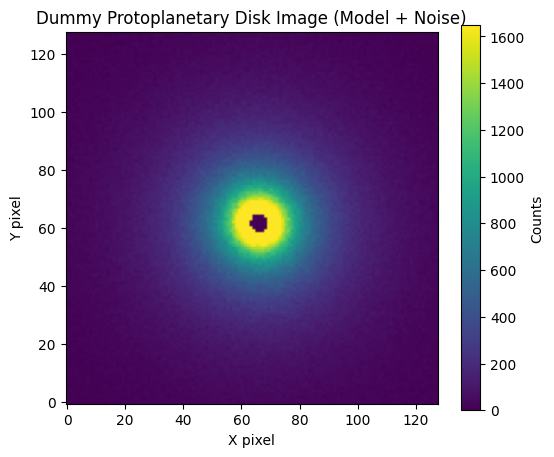

In [4]:
# --- Create a Dummy FITS Image ---
img_size = 128
y_coords, x_coords = np.ogrid[0:img_size, 0:img_size]

# True parameters for the protoplanetary disk model
true_params = {
    'x0': img_size / 2.0 - 0.5 + 2.3,
    'y0': img_size / 2.0 - 0.5 - 1.8,
    'inc_deg': 15.0,
    'pa_deg': 130.0,            # Position Angle (degrees, East of North)
    'amplitude_scale': 700.0,   # Normalization factor for brightness (e.g., in counts)
    'r_cavity': 3.0,           # Inner cavity radius in pixels
    'r_c': 30.0,                # Characteristic scaling radius in pixels
    'gamma_powerlaw': 0.8,      # Power-law index for I(r) ~ (r/r_c)^(-gamma_powerlaw)
    'gamma_taper': 1.2          # Tapering exponent for I(r) ~ exp(-(r/r_c)^gamma_taper)
}

# Calculate elliptical radius for the true geometry
true_inc_rad = np.radians(true_params['inc_deg'])
true_pa_rad = np.radians(true_params['pa_deg'])

true_dist_sq_map = tdf.calculate_elliptical_radius_squared(
    (y_coords, x_coords),
    (true_params['y0'], true_params['x0']),
    true_inc_rad,
    true_pa_rad
)

if true_dist_sq_map is None:
    raise ValueError("Failed to calculate true distance map for dummy image generation.")
# Ensure no NaNs from sqrt of tiny negative numbers if dist_sq_map had them (shouldn't for squared distances)
true_dist_map = np.sqrt(np.maximum(0, true_dist_sq_map))


# 1. Create the "true" noiseless model image (Protoplanetary Disk Model)
r_map = true_dist_map
true_signal_image = np.zeros_like(r_map, dtype=np.float64)

# Parameters from dictionary
amp = true_params['amplitude_scale']
r_cav = true_params['r_cavity']
r_char = true_params['r_c'] # Characteristic radius
gamma_pl = true_params['gamma_powerlaw']
gamma_taper = true_params['gamma_taper']

# Validate parameters to prevent math errors or undefined behavior
if r_char <= 0:
    raise ValueError("r_c (characteristic radius) must be positive.")
if amp < 0:
    raise ValueError("amplitude_scale must be non-negative.")
if gamma_taper <= 0:
    print(f"Warning: gamma_taper ({gamma_taper}) is not strictly positive; "
          "the exponential term may not act as a proper taper.")

# Define mask for calculation region based on cavity radius.
# If r_cavity is 0 AND gamma_pl is positive, I(0) would be singular (infinite).
# To avoid infinity in the image, set I(0) = 0 by excluding r=0 from calculation in that specific case.
if r_cav == 0 and gamma_pl > 0:
    # Only calculate for r > 0 if singularity at r=0 would occur
    pixels_in_disk_mask = (r_map > 0)
else:
    # Calculate for r >= r_cavity
    pixels_in_disk_mask = (r_map >= r_cav)

# Get the r values for pixels within the calculation mask
r_values_for_calc = r_map[pixels_in_disk_mask]

if r_values_for_calc.size > 0: # Proceed if there are any pixels to calculate intensity for
    # Power law term: (r / r_c)^(-gamma_pl)
    # np.power handles base=0 cases: (0/x)^y is 0 if y>0, 1 if y=0, inf if y<0.
    # This is relevant if r_cav = 0, allowing r_values_for_calc to include 0.
    # Our mask logic (if r_cav=0 and gamma_pl>0, exclude r=0) prevents inf here.
    power_law_term = (r_values_for_calc / r_char)**(-gamma_pl)
    
    # Exponential taper term: exp(-(r / r_c)^gamma_taper)
    exp_taper_term = np.exp(-(r_values_for_calc / r_char)**gamma_taper)
    
    true_signal_image[pixels_in_disk_mask] = amp * power_law_term * exp_taper_term

# Ensure true_signal_image is finite (e.g., if any np.inf was still produced by extreme parameters)
# The mask logic should prevent inf from (0/r_c)^(-gamma_pl) when gamma_pl > 0.
if not np.all(np.isfinite(true_signal_image)):
    print("Warning: Non-finite values detected in true_signal_image. Clamping infinites to 0.")
    true_signal_image = np.nan_to_num(true_signal_image, nan=0.0, posinf=0.0, neginf=0.0) # Treat inf as 0

# Ensure non-negative signal (model should already produce this if amp >=0, but as a safeguard)
true_signal_image[true_signal_image < 0] = 0


# --- Simulate Noise Consistent with Likelihood ---
sigma_background_noise_std = 5.0
simulated_brightness_floor = sigma_background_noise_std**2
print(f"Simulating with background noise std: {sigma_background_noise_std:.2f} (implies a brightness_floor ~ {simulated_brightness_floor:.2f})")

gain = 1.0
signal_in_counts = true_signal_image * gain # true_signal_image is assumed to be in 'counts'

# 2. Add Poisson-like noise to the signal part
# Ensure signal_in_counts is not negative before np.sqrt for Poisson noise scale
poisson_noise_component = np.random.normal(loc=0, scale=np.sqrt(np.maximum(0, signal_in_counts / gain)))

# 3. Add Gaussian background/detector noise
background_noise_component = np.random.normal(loc=0, scale=sigma_background_noise_std, size=true_signal_image.shape)

# 4. Combine: Noisy image = True Signal + Poisson Noise on Signal + Background Noise
dummy_image_data = true_signal_image + poisson_noise_component + background_noise_component

# Ensure final pixel values are not negative, as requested for the background noise.
dummy_image_data = np.maximum(0, dummy_image_data)
dummy_image_data = dummy_image_data.astype(np.float32)


# --- FITS File Creation ---
# Output FITS file save location is kept the same as in the problem description
dummy_fits_path = os.path.join(output_dir, "dummy_disk_image_poisson.fits") 
hdu = fits.PrimaryHDU(data=dummy_image_data)
hdu.header['OBJECT'] = 'Dummy Protoplanetary Disk' # Updated object name to reflect new model
hdu.header['BUNIT'] = 'Counts'
hdu.header['SIGBKG'] = (sigma_background_noise_std, 'Simulated background RMS noise')
hdu.header['GAIN'] = (gain, 'Assumed gain for Poisson noise')

# Add model parameters to header for reference
hdu.header['MODEL'] = ('PPDISK_RADIAL', 'Disk model type')
hdu.header['X0'] = (true_params['x0'], 'Center X (pix, 0-indexed)')
hdu.header['Y0'] = (true_params['y0'], 'Center Y (pix, 0-indexed)')
hdu.header['INC_DEG'] = (true_params['inc_deg'], 'Inclination (deg)')
hdu.header['PA_DEG'] = (true_params['pa_deg'], 'Position Angle (deg E of N)')
hdu.header['AMPSCALE'] = (true_params['amplitude_scale'], 'Amplitude scaling factor')
hdu.header['RCAVITY'] = (true_params['r_cavity'], 'Cavity radius (pix)')
hdu.header['RC'] = (true_params['r_c'], 'Characteristic radius (pix)')
hdu.header['GAMMAPL'] = (true_params['gamma_powerlaw'], 'Power-law index gamma')
hdu.header['GAMMATAP'] = (true_params['gamma_taper'], 'Tapering exponent gamma_exp')

# Standard WCS keywords (kept as in original snippet)
# Note: CRPIX values (img_size / 2.0) might be non-standard if they refer to pixel edge.
# Conventionally, CRPIX is 1-indexed and refers to pixel center (e.g., img_size / 2.0 + 0.5).
# We keep them as they were to not change this aspect.
hdu.header['CDELT1'] = -0.05 / 3600.0 # degrees/pixel
hdu.header['CDELT2'] = 0.05 / 3600.0  # degrees/pixel
hdu.header['CRPIX1'] = img_size / 2.0 
hdu.header['CRPIX2'] = img_size / 2.0 
hdu.header['CRVAL1'] = 150.0 # RA at reference pixel (degrees)
hdu.header['CRVAL2'] = -30.0 # Dec at reference pixel (degrees)
hdu.header['CTYPE1'] = 'RA---TAN'
hdu.header['CTYPE2'] = 'DEC--TAN'
hdu.header['EQUINOX'] = 2000.0

hdu.writeto(dummy_fits_path, overwrite=True)
print(f"Dummy FITS image with protoplanetary disk model created: {dummy_fits_path}")

# Display the dummy image
plt.figure(figsize=(6,5))
# Use a robust min/max for visualization, e.g., percentiles or based on noise
vmin_plot = 0  # Since we clipped at 0
vmax_plot = np.percentile(dummy_image_data[dummy_image_data > 0], 99) if np.any(dummy_image_data > 0) else 1.0
if vmax_plot <= vmin_plot : vmax_plot = vmin_plot + 1 # handle edge case of all zero or uniform image after clipping
plt.imshow(dummy_image_data, origin='lower', cmap='viridis', 
           vmin=vmin_plot, 
           vmax=vmax_plot)
plt.colorbar(label=hdu.header.get('BUNIT', 'Intensity'))
plt.title("Dummy Protoplanetary Disk Image (Model + Noise)")
plt.xlabel("X pixel")
plt.ylabel("Y pixel")
plt.show()

In [3]:
# --- Generate and Save a Default Configuration ---
default_config_path = os.path.join(output_dir, "default_config.toml")
tdf.save_default_config(default_config_path)
print(f"Default configuration template saved to: {default_config_path}")
# You can inspect this file to see all available options.

2025-05-21 17:04:37,422 - toydiskgeofitter.config - INFO - Default configuration template saved to example_output/default_config.toml


Default configuration template saved to: example_output/default_config.toml


In [4]:
# --- Generate and Save a Default Configuration ---
default_config_path = os.path.join(output_dir, "default_config.toml")
tdf.save_default_config(default_config_path)
print(f"Default configuration template saved to: {default_config_path}")
# You can inspect this file to see all available options.

# --- Create a Specific Configuration for Our Dummy Data ---
# For a real case, you would typically copy the default_config.toml,
# rename it (e.g., my_fit_config.toml), and edit it.
# Here, we'll create one programmatically.

custom_config_dict = {
    "observations": {
        "image_paths": [dummy_fits_path],
        "hdu_indices": [0],
        "data_labels": ["DummyDisk"],
        "pixel_scale_arcsec": 0.05, # Can be auto-detected if CDELT is in header
        "distance_pc": 100.0,
    },
    "fitting_parameters": { # Parameters to fit
        # Initial guesses are near the image center but not exact
        "x0": {"guess": img_size / 2.0, "prior_type": "uniform", "prior_args": [img_size*0.3, img_size*0.7], "fit": True, "label": r"$x_0$ (pix)"},
        "y0": {"guess": img_size / 2.0, "prior_type": "uniform", "prior_args": [img_size*0.3, img_size*0.7], "fit": True, "label": r"$y_0$ (pix)"},
        "inc_deg": {"guess": 20.0, "prior_type": "uniform", "prior_args": [0.0, 45.0], "fit": True, "label": r"$i$ (deg)"},
        "pa_deg": {"guess": 120.0, "prior_type": "uniform", "prior_args": [0.0, 180.0], "fit": True, "label": r"PA (deg)"},
        #"pa_deg": {"value": 130.0, "fit": False, "label": "PA (deg)"}
        # Example of a fixed parameter (not used in this simple geometric fit likelihood)
        # "flux_scale": {"value": 1.0, "fit": False, "label": "Flux Scale"}
    },
    "fitting_regions": [{ # Defines the annuli for likelihood calculation
        "name": "disk_fit_region",
        "r_min_pixels": 5.0,
        "r_max_pixels": (img_size / 2.0) * 0.8, # Fit out to 80% of image half-size
        "annulus_width_pixels": 2.0,
        "brightness_floor_percentile": 10.0 # Lower percentile for noise floor
    }],
    "mcmc_settings": {
        "sampler": "emcee",
        "nwalkers": 32,       # Number of MCMC walkers
        "nsteps": 5000,       # Total MCMC steps per walker (use more for a real fit, e.g., 5000+)
        "nburn": 50,         # "Burn-in" steps to discard (e.g., 500+)
        "thin_by": 10,        # Thinning factor
        "threads": 4,         # Number of threads (-1 for all, 1 for no multiprocessing)
        "initial_ball_scale": 1e-2,
        "save_sampler": True,
        "sampler_output_path": "dummy_sampler.pkl",
    },
    "output_settings": {
        "results_directory": output_dir, # Subdirectory for plots and results
        "plot_chains": True,
        "plot_corner": True,
        "plot_radial_profile": True,
    },
    "profile_calculation": {
        "binning_mode": "linear",
        "linear_bin_size_px": 3.0,
        "outlier_clip_fraction": 0.05,
        "use_elliptical_bins": True,
        "plot_sb_r_squared": False, # For this example, just plot SB
        "statistic": "mean",
        "min_pixels_per_bin": 5,
    },
    "plotting_settings": {
        "output_format": "png",
        "dpi": 100,
        "chains_plot_filename": "mcmc_chains_dummy.{output_format}",
        "corner_plot_filename": "mcmc_corner_dummy.{output_format}",
        "profile_plot_filename": "radial_profile_dummy.{output_format}",
        "image_bunit_default": "Intensity"
    }
}

# Save this custom config to a TOML file
custom_config_path = os.path.join(output_dir, "custom_dummy_config.toml")
import toml
with open(custom_config_path, 'w') as f:
    toml.dump(custom_config_dict, f)
print(f"Custom configuration for dummy data saved to: {custom_config_path}")

# --- Load the Configuration ---
cfg = tdf.load_config(custom_config_path)
print("\nLoaded configuration snippet (fitting_parameters):")
print(cfg.get("fitting_parameters"))

2025-05-21 17:04:38,083 - toydiskgeofitter.config - INFO - Default configuration template saved to example_output/default_config.toml
2025-05-21 17:04:38,085 - toydiskgeofitter.config - INFO - Configuration loaded from example_output/custom_dummy_config.toml


Default configuration template saved to: example_output/default_config.toml
Custom configuration for dummy data saved to: example_output/custom_dummy_config.toml

Loaded configuration snippet (fitting_parameters):
{'x0': {'guess': 64.0, 'prior_type': 'uniform', 'prior_args': [38.4, 89.6], 'fit': True, 'label': '$x_0$ (pix)'}, 'y0': {'guess': 64.0, 'prior_type': 'uniform', 'prior_args': [38.4, 89.6], 'fit': True, 'label': '$y_0$ (pix)'}, 'inc_deg': {'guess': 20.0, 'prior_type': 'uniform', 'prior_args': [0.0, 45.0], 'fit': True, 'label': '$i$ (deg)'}, 'pa_deg': {'guess': 120.0, 'prior_type': 'uniform', 'prior_args': [0.0, 180.0], 'fit': True, 'label': 'PA (deg)'}}


In [5]:
# --- Load Image Data specified in config ---
# For this example, we only have one image
image_path = cfg["observations"]["image_paths"][0]
hdu_idx = cfg["observations"]["hdu_indices"][0]

image_data, header, wcs_obj = tdf.load_fits_image(image_path, hdu_index=hdu_idx, return_wcs=True)

if image_data is None:
    raise ValueError("Failed to load image data.")

print(f"\nImage '{image_path}' loaded. Shape: {image_data.shape}")

2025-05-21 17:04:38,834 - toydiskgeofitter.io - INFO - Successfully loaded image data and header from example_output/dummy_disk_image_poisson.fits, HDU 0.



Image 'example_output/dummy_disk_image_poisson.fits' loaded. Shape: (128, 128)


In [6]:
# --- (Optional) Update config from FITS header ---
# This step can auto-populate things like pixel_scale or update parameter guesses
# cfg = tdf.update_config_from_fits_header(cfg, header, image_data.shape, image_index=0)
# print("x0 guess after FITS header update (if it was generic):", cfg["fitting_parameters"]["x0"]["guess"])

In [7]:
# --- Prepare Data for Fitting (Masking, 1D arrays, etc.) ---
# This part is crucial and involves more detailed logic based on your `log_likelihood_annuli_variance`

# 1. Define parameters to fit and their initial guesses
fit_params_config = cfg["fitting_parameters"]
param_names_to_fit = [name for name, p_cfg in fit_params_config.items() if p_cfg.get("fit", False)]
fixed_params_dict = {name: p_cfg.get("value") for name, p_cfg in fit_params_config.items() if not p_cfg.get("fit", False)}
ndim = len(param_names_to_fit)

print(f"\nParameters to fit ({ndim}D): {param_names_to_fit}")
print(f"Fixed parameters: {fixed_params_dict}")



Parameters to fit (4D): ['x0', 'y0', 'inc_deg', 'pa_deg']
Fixed parameters: {}


In [8]:
# --- (Optional) Update config ---
cfg = tdf.load_config(custom_config_path)

2025-05-21 17:04:39,961 - toydiskgeofitter.config - INFO - Configuration loaded from example_output/custom_dummy_config.toml


In [9]:
# 2. Define fitting region and annuli (using the first region in config)
fit_region_cfg = cfg["fitting_regions"][0]
r_min_px = fit_region_cfg["r_min_pixels"]
r_max_px = fit_region_cfg["r_max_pixels"]
ann_width_px = fit_region_cfg["annulus_width_pixels"]

# Define annuli edges (actual radii, not squared yet)
# For likelihood, these should correspond to semi-major axis if fitting ellipses
fit_annuli_r_edges = tdf.define_annuli_edges(r_min_px, r_max_px, annulus_width=ann_width_px)
fit_annuli_r_sq_edges = fit_annuli_r_edges**2 # Likelihood uses squared radii
print(f"\nDefined {len(fit_annuli_r_edges)-1} annuli for likelihood from r={r_min_px} to r={r_max_px} px.")


Defined 24 annuli for likelihood from r=5.0 to r=51.2 px.


In [10]:
# 3. Create a rough mask for the fitting region to speed up by selecting relevant pixels
# This mask is based on circular radii from an initial guess of the center
# The elliptical calculations in the likelihood will then select from these pixels.
ny, nx = image_data.shape
initial_center_guess_x = fit_params_config["x0"]["guess"]
initial_center_guess_y = fit_params_config["y0"]["guess"]

# Full 2D coordinate grids
y_coords_full, x_coords_full = np.ogrid[0:ny, 0:nx]

# Circular distance from initial guess (squared)
dist_sq_from_guess_center_2d = (x_coords_full - initial_center_guess_x)**2 + \
                               (y_coords_full - initial_center_guess_y)**2

# Mask pixels roughly within the fitting annuli range, plus some buffer
# Max radius considered for this initial mask should be r_max_px + some margin for center offset
buffer_for_center_offset = np.max([np.abs(pcfg['prior_args'][1] - pcfg['prior_args'][0]) for pcfg in [fit_params_config['x0'],fit_params_config['y0']]])
max_mask_r = r_max_px + buffer_for_center_offset

# This mask defines the region from which pixels are taken for the 1D arrays passed to likelihood
fitting_region_mask_2d = (dist_sq_from_guess_center_2d < max_mask_r**2) & \
                         (dist_sq_from_guess_center_2d > (max(0,r_min_px - ann_width_px))**2) # include a bit inside min for edge cases


# These are the 1D arrays of pixel values and their coordinates
image_to_fit_masked_values_1d = image_data[fitting_region_mask_2d]
y_coords_masked_1d, x_coords_masked_1d = np.where(fitting_region_mask_2d)
coords_yx_masked_1d_tuple = (y_coords_masked_1d, x_coords_masked_1d)

print(f"Selected {len(image_to_fit_masked_values_1d)} pixels for fitting based on initial mask.")
if len(image_to_fit_masked_values_1d) == 0:
    raise ValueError("No pixels selected for fitting. Check fitting_regions and image content.")

Selected 16355 pixels for fitting based on initial mask.


In [11]:
# 4. Calculate brightness floor
bf_percentile = fit_region_cfg["brightness_floor_percentile"]
finite_masked_pixels = image_to_fit_masked_values_1d[np.isfinite(image_to_fit_masked_values_1d)]
if len(finite_masked_pixels) > 0:
    brightness_floor_val = np.percentile(finite_masked_pixels, bf_percentile)
else:
    brightness_floor_val = 0.0
    print("Warning: No finite pixels in masked region for brightness floor, setting to 0.")
print(f"Brightness floor value (percentile {bf_percentile}%): {brightness_floor_val:.3e}")

Brightness floor value (percentile 10.0%): 1.775e+01


In [12]:
# --- Build Log Prior Function ---
# The prior function will use the 'fitting_parameters' section of the config
log_prior_obj = tdf.build_log_prior_object(
    param_names_to_fit,
    fit_params_config,
    image_ny_nx=(ny, nx) # For boundary checks on x0, y0
)
log_prior_func = log_prior_obj # Keep variable name for clarity or direct use if needed

print("\nLog prior object created.")

# --- Prepare Static Arguments for Log Likelihood ---
# These are arguments to log_likelihood_annuli_variance that don't change per MCMC step
likelihood_static_args = (
    param_names_to_fit, # Names of parameters in theta passed by emcee
    image_to_fit_masked_values_1d,
    coords_yx_masked_1d_tuple,
    fit_annuli_r_sq_edges,
    brightness_floor_val,
    fixed_params_dict
)

# --- Build Log Probability Function ---
log_probability_obj = tdf.make_log_probability_object(
    log_prior_func,
    tdf.log_likelihood_annuli_variance, # The chosen likelihood function
    likelihood_static_args
)
log_probability_func = log_probability_obj # This is the LogProbabilityWrapper instance

print("Log probability object created.")

# Test the log_probability with initial guesses (should not be -inf)
initial_guess_theta = [fit_params_config[pname]["guess"] for pname in param_names_to_fit]
test_log_prob_val = log_probability_func(tuple(initial_guess_theta))
print(f"Log probability at initial guess ({initial_guess_theta}): {test_log_prob_val:.3e}")
if not np.isfinite(test_log_prob_val):
    print("Warning! Log probability is not finite at initial guess. Check priors or likelihood inputs.")
    # This often means initial guess is outside prior range or leads to bad likelihood (e.g. inc_deg=90)


Log prior object created.
Log probability object created.
Log probability at initial guess ([64.0, 64.0, 20.0, 120.0]): -4.117e+04


In [13]:
mcmc_cfg = cfg["mcmc_settings"]

# --- Initialize Walkers ---
initial_walker_positions = tdf.initialize_walkers(
    nwalkers=mcmc_cfg["nwalkers"],
    fit_param_names=param_names_to_fit,
    param_configs=fit_params_config,
    initialization_strategy="ball", # "ball" or "prior"
    ball_scale=mcmc_cfg["initial_ball_scale"]
)
print(f"\nInitialized {mcmc_cfg['nwalkers']} walkers with {ndim} dimensions.")

# --- Run MCMC Sampler ---
# Determine if multiprocessing should be used
use_mp = True if mcmc_cfg.get("threads", 1) != 1 else False
num_threads_mcmc = mcmc_cfg.get("threads", 1)

print(f"Starting MCMC run with {mcmc_cfg['nsteps']} steps...")
sampler = tdf.run_mcmc_sampler(
    log_probability_func,
    initial_walker_positions,
    nwalkers=mcmc_cfg["nwalkers"],
    nsteps=mcmc_cfg["nsteps"],
    ndim=ndim,
    mcmc_config=mcmc_cfg, # Pass the sub-config for MCMC
    use_multiprocessing=use_mp,
    num_threads=num_threads_mcmc
)
print("MCMC run finished.")

# --- (Optional) Save the Sampler ---
if mcmc_cfg.get("save_sampler", False):
    sampler_path = mcmc_cfg["sampler_output_path"]
    sampler_full_path = os.path.join(output_dir, sampler_path)
    tdf.save_mcmc_sampler(sampler, sampler_full_path)
    print(f"Sampler object saved to: {sampler_full_path}")

2025-05-21 17:04:41,226 - toydiskgeofitter.fitting - INFO - Using multiprocessing with 4 threads.



Initialized 32 walkers with 4 dimensions.
Starting MCMC run with 5000 steps...


2025-05-21 17:04:41,264 - toydiskgeofitter.fitting - INFO - Running MCMC with 32 walkers for 5000 steps...
100%|██████████| 5000/5000 [00:48<00:00, 102.97it/s]
2025-05-21 17:05:30,662 - toydiskgeofitter.fitting - INFO - MCMC run completed in 49.40 seconds.
2025-05-21 17:05:30,894 - toydiskgeofitter.fitting - INFO - Multiprocessing pool (managed by this function call) closed and joined.
2025-05-21 17:05:30,897 - toydiskgeofitter.io - INFO - MCMC sampler saved to example_output/dummy_sampler.pkl


MCMC run finished.
Sampler object saved to: example_output/dummy_sampler.pkl


In [14]:
# --- Process Sampler Output ---
samples_chain, flat_samples, best_fit_summary, convergence_diagnostics = tdf.process_sampler_output(
    sampler,
    param_names_to_fit,
    nburn=mcmc_cfg["nburn"],
    thin=mcmc_cfg["thin_by"]
)

if flat_samples is None:
    raise RuntimeError("MCMC processing failed, no samples obtained.")

print("\n--- MCMC Best-Fit Parameters (median +/- 1-sigma errors) ---")
for pname, pvals in best_fit_summary.items():
    print(f"  {fit_params_config[pname].get('label', pname):<20s}: "
          f"{pvals['median']:.3f} (+{pvals['upper_err']:.3f} / -{pvals['lower_err']:.3f})")

print("\n--- Convergence Diagnostics ---")
for key, val in convergence_diagnostics.items():
    if isinstance(val, (list, np.ndarray)):
        print(f"  {key}: {np.round(val, 3)}")
    else:
        print(f"  {key}: {val:.3f}" if isinstance(val, float) else f"  {key}: {val}")


# --- Plot MCMC Chains ---
plot_cfg = cfg["plotting_settings"]
if cfg["output_settings"].get("plot_chains", False) and samples_chain is not None:
    chains_plot_file = os.path.join(
        cfg["output_settings"]["results_directory"],
        plot_cfg["chains_plot_filename"].format(output_format=plot_cfg["output_format"])
    )
    param_labels_for_plot = [fit_params_config[pname].get("label", pname) for pname in param_names_to_fit]
    
    tdf.plot_mcmc_chains(
        samples_chain,
        param_labels_for_plot,
        output_file=chains_plot_file,
        title=f"MCMC Chains for {cfg['observations']['data_labels'][0]}",
        nwalkers_to_show=16 # Show a subset of walkers for clarity
    )
    print(f"MCMC chains plot saved to {chains_plot_file} (if it didn't show inline).")

# --- Plot Corner Diagram ---
if cfg["output_settings"].get("plot_corner", False) and flat_samples is not None:
    corner_plot_file = os.path.join(
        cfg["output_settings"]["results_directory"],
        plot_cfg["corner_plot_filename"].format(output_format=plot_cfg["output_format"])
    )
    # Get median values as "truths" for the corner plot
    truths_for_corner = [best_fit_summary[pname]["median"] for pname in param_names_to_fit]
    
    tdf.plot_corner_mcmc(
        flat_samples,
        param_labels_for_plot, # Use the same labels as for chains
        truths=truths_for_corner,
        output_file=corner_plot_file,
        title=f"MCMC Posteriors for {cfg['observations']['data_labels'][0]}"
    )
    print(f"Corner plot saved to {corner_plot_file} (if it didn't show inline).")
    
# --- Display Truths vs Fitted for our Dummy Data ---
print("\n--- Comparison with True Parameters (for dummy data) ---")
for pname_fit in param_names_to_fit:
    # map fit param name (e.g. x0) to true param name (e.g. x0)
    true_val = true_params.get(pname_fit)
    if true_val is not None:
        fitted_median = best_fit_summary[pname_fit]["median"]
        fitted_lower_err = best_fit_summary[pname_fit]["lower_err"]
        fitted_upper_err = best_fit_summary[pname_fit]["upper_err"]
        sigma_diff = (fitted_median - true_val) / (0.5 * (fitted_lower_err + fitted_upper_err)) if (fitted_lower_err + fitted_upper_err) > 0 else np.inf
        
        print(f"  {fit_params_config[pname_fit].get('label', pname_fit):<20s}: "
              f"True={true_val:.3f}, "
              f"Fit={fitted_median:.3f} (+{fitted_upper_err:.3f}/-{fitted_lower_err:.3f}) "
              f"({sigma_diff:.1f} sigma diff)")

2025-05-21 17:05:30,908 - toydiskgeofitter.fitting - INFO - Processing sampler output: Discarding 50 burn-in steps, thinning by 10.
2025-05-21 17:05:30,909 - toydiskgeofitter.fitting - INFO - x0: 65.825 (+0.011 / -0.057)
2025-05-21 17:05:30,910 - toydiskgeofitter.fitting - INFO - y0: 61.704 (+0.014 / -0.010)
2025-05-21 17:05:30,912 - toydiskgeofitter.fitting - INFO - inc_deg: 13.706 (+0.578 / -0.158)
2025-05-21 17:05:30,913 - toydiskgeofitter.fitting - INFO - pa_deg: 124.989 (+2.343 / -1.720)
2025-05-21 17:05:30,913 - toydiskgeofitter.fitting - INFO - Mean acceptance fraction: 0.083
2025-05-21 17:05:30,913 - toydiskgeofitter.fitting - WARNING - Acceptance fraction may indicate poor sampling efficiency (ideal: ~0.2-0.5).
2025-05-21 17:05:30,979 - toydiskgeofitter.fitting - INFO - Autocorrelation time estimates: [277.46417248 335.73452224 246.5264864  345.30442417]
2025-05-21 17:05:30,979 - toydiskgeofitter.fitting - INFO - Estimated effective number of samples: 53
2025-05-21 17:05:30,97


--- MCMC Best-Fit Parameters (median +/- 1-sigma errors) ---
  $x_0$ (pix)         : 65.825 (+0.011 / -0.057)
  $y_0$ (pix)         : 61.704 (+0.014 / -0.010)
  $i$ (deg)           : 13.706 (+0.578 / -0.158)
  PA (deg)            : 124.989 (+2.343 / -1.720)

--- Convergence Diagnostics ---
  mean_acceptance_fraction: 0.083
  autocorrelation_time: [277.464 335.735 246.526 345.304]
  effective_samples: 52.580


2025-05-21 17:05:31,118 - toydiskgeofitter.plotting - INFO - MCMC chains plot saved to example_output/mcmc_chains_dummy.png


MCMC chains plot saved to example_output/mcmc_chains_dummy.png (if it didn't show inline).


2025-05-21 17:05:31,303 - toydiskgeofitter.plotting - INFO - Corner plot saved to example_output/mcmc_corner_dummy.png


Corner plot saved to example_output/mcmc_corner_dummy.png (if it didn't show inline).

--- Comparison with True Parameters (for dummy data) ---
  $x_0$ (pix)         : True=65.800, Fit=65.825 (+0.011/-0.057) (0.7 sigma diff)
  $y_0$ (pix)         : True=61.700, Fit=61.704 (+0.014/-0.010) (0.3 sigma diff)
  $i$ (deg)           : True=15.000, Fit=13.706 (+0.578/-0.158) (-3.5 sigma diff)
  PA (deg)            : True=130.000, Fit=124.989 (+2.343/-1.720) (-2.5 sigma diff)


In [15]:
profile_calc_cfg = cfg["profile_calculation"]
if cfg["output_settings"].get("plot_radial_profile", False):
    print("\n--- Calculating Radial Profile using Best-Fit Geometry ---")
    
    # Extract best-fit geometric parameters
    # Ensure all necessary geometry parameters are available from the fit or fixed_params
    best_fit_geom_for_profile = {}
    for p_needed in ['x0', 'y0', 'inc_deg', 'pa_deg']:
        if p_needed in best_fit_summary:
            best_fit_geom_for_profile[p_needed] = best_fit_summary[p_needed]['median']
        elif p_needed in fixed_params_dict:
            best_fit_geom_for_profile[p_needed] = fixed_params_dict[p_needed]
        else:
            raise ValueError(f"Parameter '{p_needed}' needed for profile geometry not found in fit or fixed params.")

    # 1. Generate distance map based on best-fit geometry
    profile_type = "elliptical" if profile_calc_cfg["use_elliptical_bins"] else "circular"
    distance_map_for_profile_sq = tdf.generate_profile_distance_map(
        image_data.shape,
        best_fit_geom_for_profile,
        profile_type=profile_type
    )
    if distance_map_for_profile_sq is None:
        raise RuntimeError("Failed to generate distance map for radial profile.")
    
    # 2. Define profile bin edges (actual radii, not squared)
    # Using different settings for illustration, or could reuse fit_annuli_r_edges
    # For this example, let's define new bins based on profile_calc_cfg
    prof_r_min = profile_calc_cfg.get("min_radius_px_log", 1.0) if profile_calc_cfg["binning_mode"] == "log" else 0.0
    prof_r_max = r_max_px # Use the same r_max as fitting for consistency
    
    if profile_calc_cfg["binning_mode"] == "log":
        profile_radii_edges = tdf.define_annuli_edges(
            prof_r_min, prof_r_max, 
            num_annuli=profile_calc_cfg.get("num_log_bins", 30), 
            log_spacing=True
        )
    else: # linear
        profile_radii_edges = tdf.define_annuli_edges(
            prof_r_min, prof_r_max, 
            annulus_width=profile_calc_cfg["linear_bin_size_px"]
        )
    
    # 3. Calculate the radial profile
    # We don't have an uncertainty_map for the dummy data, so it will be unweighted.
    (prof_bin_centers, prof_stat, 
     prof_std, prof_err, prof_N_pixels) = tdf.calculate_radial_profile(
        image_data,
        distance_map_for_profile_sq,
        profile_radii_edges,
        uncertainty_map=None, # Provide one if you have it
        outlier_clip_fraction=profile_calc_cfg["outlier_clip_fraction"],
        statistic=profile_calc_cfg["statistic"],
        min_pixels_per_bin=profile_calc_cfg["min_pixels_per_bin"]
    )
    print(f"Radial profile calculated with {len(prof_bin_centers)} bins.")

    # 4. Plot the radial profile
    profile_plot_file = os.path.join(
        cfg["output_settings"]["results_directory"],
        plot_cfg["profile_plot_filename"].format(output_format=plot_cfg["output_format"])
    )
    
    # Prepare data for the plotting function
    profile_data_to_plot = [{
        'radii': prof_bin_centers, # The calculate_radial_profile returns bin centers
        'profile_stat': prof_stat,
        'profile_err': prof_err, # Error on the statistic
        'label': cfg["observations"]["data_labels"][0], # Label for the dataset
        'color': 'dodgerblue',
        'fill_color': 'lightskyblue'
    }]
    
    # Construct plot_config for the radial profile plot
    # This aggregates settings from various parts of the main config
    radial_plot_specific_config = {
        'x_scale': 'linear' if profile_calc_cfg["binning_mode"] == "linear" else 'log',
        'y_scale': 'linear', # Can be customized, e.g. 'log' for SB
        'radius_label_base': "Semi-Major Axis" if profile_calc_cfg["use_elliptical_bins"] else "Radius",
        'plot_sb_r_squared': profile_calc_cfg["plot_sb_r_squared"],
        'image_filter_name': header.get("FILTER", header.get("OBJECT", "N/A")), # Example: get from FITS
        'outlier_clip_fraction': profile_calc_cfg["outlier_clip_fraction"],
        'binning_mode_desc': f"{profile_calc_cfg['binning_mode'].capitalize()} {'Elliptical' if profile_calc_cfg['use_elliptical_bins'] else 'Circular'} Bins",
        'image_bunit': header.get("BUNIT", plot_cfg.get("image_bunit_default", "Intensity"))
    }

    tdf.plot_radial_profiles(
        profile_data_to_plot,
        plot_config=radial_plot_specific_config,
        obs_config=cfg["observations"], # For unit conversions
        fit_geometry_params=best_fit_geom_for_profile, # For info text box
        output_file=profile_plot_file,
        title_prefix=f"Radial Profile of {cfg['observations']['data_labels'][0]}"
    )
    print(f"Radial profile plot saved to {profile_plot_file} (if it didn't show inline).")



--- Calculating Radial Profile using Best-Fit Geometry ---
Radial profile calculated with 18 bins.


2025-05-21 17:05:31,396 - toydiskgeofitter.plotting - INFO - Radial profile plot saved to example_output/radial_profile_dummy.png


Radial profile plot saved to example_output/radial_profile_dummy.png (if it didn't show inline).


In [16]:
# --- Save a Summary of Best-Fit Results ---
# This could be a text file, JSON, or part of a more complex HDF5 structure
results_summary_path = os.path.join(cfg["output_settings"]["results_directory"], "fit_summary_results.txt")

with open(results_summary_path, 'w') as f:
    f.write(f"# Fit Summary for: {cfg['observations']['data_labels'][0]}\n")
    f.write(f"# Configuration file used: {custom_config_path}\n\n")
    f.write("--- Best-Fit Parameters (median +/- 1-sigma percentile errors) ---\n")
    for pname, pvals in best_fit_summary.items():
        label = fit_params_config[pname].get('label', pname)
        f.write(f"  {label:<20s}: {pvals['median']:.4f} (+{pvals['upper_err']:.4f} / -{pvals['lower_err']:.4f})\n")
    
    f.write("\n--- Convergence Diagnostics ---\n")
    for key, val in convergence_diagnostics.items():
        if isinstance(val, (list, np.ndarray)):
            f.write(f"  {key}: {np.round(val, 3)}\n")
        else:
            f.write(f"  {key}: {val:.3f}\n" if isinstance(val, float) else f"  {key}: {val}\n")
            
    # Optionally, save the best_fit_summary dictionary itself using pickle or JSON
    # tdf.save_fit_results(best_fit_summary, results_summary_path.replace(".txt", "_dict.pkl"))

print(f"\nFit summary saved to: {results_summary_path}")


Fit summary saved to: example_output/fit_summary_results.txt


# Pipeline API

In [1]:
import os
import toydiskgeofitter as tdf
import logging
source_dir = "example_output"
tdf.setup_logging(level='INFO') # Set to 'DEBUG' for more verbose output
custom_config_path = os.path.join(source_dir, "custom_dummy_config.toml")
dummy_fits_path = os.path.join(source_dir, "dummy_disk_image_poisson.fits")

2025-05-21 17:08:00,153 - toydiskgeofitter.utils - INFO - Logging setup with level INFO. Output to: Console


In [2]:
# Ensure the custom_config_path is still valid from Cell 4
print(f"\n--- Testing High-Level Pipeline API ---")
print(f"Using configuration: {custom_config_path}")
print(f"Using dummy image: {dummy_fits_path}") # From Cell 3

# Define a new output directory for the pipeline test to avoid overwriting previous manual steps
pipeline_output_dir = "pipeline_run_output"
os.makedirs(pipeline_output_dir, exist_ok=True)
print(f"Pipeline output will be in: {pipeline_output_dir}")

# Make sure logging is set up if the notebook kernel was restarted
import logging
if not logging.getLogger().hasHandlers():
    tdf.setup_logging(level='INFO')


# Call the pipeline function
pipeline_results = tdf.fit_disk_pipeline(
    config_file_path=custom_config_path,
    # image_file_path=dummy_fits_path, # Already in custom_dummy_config.toml
    output_directory_override=pipeline_output_dir
)

if pipeline_results:
    print("\nPipeline completed successfully!")
    print(f"Best fit for x0: {pipeline_results['best_fit_summary']['x0']['median']:.3f}")
    print(f"Paths to generated outputs: {pipeline_results['output_paths']}")
    
    # You can now access all results from the pipeline_results dictionary
    # For example, to show the corner plot generated by the pipeline:
    # from IPython.display import Image
    # corner_plot_by_pipeline = pipeline_results.get("output_paths", {}).get("corner_plot")
    # if corner_plot_by_pipeline and os.path.exists(corner_plot_by_pipeline):
    #     print(f"\nDisplaying corner plot from pipeline run: {corner_plot_by_pipeline}")
    #     #display(Image(filename=corner_plot_by_pipeline)) # Uncomment to display if desired
else:
    print("\nPipeline run encountered an error or returned no results.")
        
# --- End of the Notebook ---
print("\n--- Example Notebook Finished ---")

2025-05-21 17:08:00,521 - toydiskgeofitter.pipeline - INFO - --- Starting Toy Disk Geo Fitter Pipeline v0.1.0 ---
2025-05-21 17:08:00,522 - toydiskgeofitter.pipeline - INFO - Using configuration file: example_output/custom_dummy_config.toml
2025-05-21 17:08:00,524 - toydiskgeofitter.config - INFO - Configuration loaded from example_output/custom_dummy_config.toml
2025-05-21 17:08:00,524 - toydiskgeofitter.pipeline - INFO - Output directory overridden to: pipeline_run_output
2025-05-21 17:08:00,525 - toydiskgeofitter.pipeline - INFO - Results will be saved in: pipeline_run_output
2025-05-21 17:08:00,536 - toydiskgeofitter.io - INFO - Successfully loaded image data and header from example_output/dummy_disk_image_poisson.fits, HDU 0.
2025-05-21 17:08:00,537 - toydiskgeofitter.pipeline - INFO - Image 'example_output/dummy_disk_image_poisson.fits' loaded. Shape: (128, 128)
2025-05-21 17:08:00,538 - toydiskgeofitter.pipeline - INFO - Parameters to fit (4D): ['x0', 'y0', 'inc_deg', 'pa_deg']



--- Testing High-Level Pipeline API ---
Using configuration: example_output/custom_dummy_config.toml
Using dummy image: example_output/dummy_disk_image_poisson.fits
Pipeline output will be in: pipeline_run_output


2025-05-21 17:08:00,572 - toydiskgeofitter.fitting - INFO - Running MCMC with 32 walkers for 5000 steps...
100%|██████████| 5000/5000 [00:47<00:00, 105.25it/s]
2025-05-21 17:08:48,798 - toydiskgeofitter.fitting - INFO - MCMC run completed in 48.22 seconds.
2025-05-21 17:08:49,009 - toydiskgeofitter.fitting - INFO - Multiprocessing pool (managed by this function call) closed and joined.
2025-05-21 17:08:49,010 - toydiskgeofitter.fitting - INFO - Processing sampler output: Discarding 50 burn-in steps, thinning by 10.
2025-05-21 17:08:49,011 - toydiskgeofitter.fitting - INFO - x0: 65.776 (+0.052 / -0.003)
2025-05-21 17:08:49,012 - toydiskgeofitter.fitting - INFO - y0: 61.758 (+0.009 / -0.010)
2025-05-21 17:08:49,012 - toydiskgeofitter.fitting - INFO - inc_deg: 16.513 (+0.816 / -0.084)
2025-05-21 17:08:49,013 - toydiskgeofitter.fitting - INFO - pa_deg: 134.033 (+0.484 / -4.712)
2025-05-21 17:08:49,013 - toydiskgeofitter.fitting - INFO - Mean acceptance fraction: 0.166
2025-05-21 17:08:49,0


Pipeline completed successfully!
Best fit for x0: 65.776
Paths to generated outputs: {'sampler': 'pipeline_run_output/dummy_sampler.pkl', 'fit_summary_text': 'pipeline_run_output/fit_summary_results.txt', 'best_fit_summary_toml': 'pipeline_run_output/best_fit_summary.toml', 'chains_plot': 'pipeline_run_output/mcmc_chains_dummy.png', 'corner_plot': 'pipeline_run_output/mcmc_corner_dummy.png', 'radial_profile_plot': 'pipeline_run_output/radial_profile_dummy.png'}

--- Example Notebook Finished ---
